In [1]:
import sys
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
from autograd.numpy import pi, mat, cos, sin, zeros, eye, array
import autograd.numpy as np
from autograd.numpy import concatenate

def rotx(theta):
    """
    Rotation about X-axis

    @type theta: number
    @param theta: the rotation angle
    @rtype: 3x3 orthonormal matrix
    @return: rotation about X-axis

    @see: L{roty}, L{rotz}, L{rotvec}
    """

    ct = cos(theta)
    st = sin(theta)
    return np.array([[1,  0,    0,  0],
                     [0,  ct, -st,  0],
                     [0,  st,  ct,  0],
                     [0,  0,    0,  1]])

def roty(theta):
    """
    Rotation about Y-axis

    @type theta: number
    @param theta: the rotation angle
    @rtype: 3x3 orthonormal matrix
    @return: rotation about Y-axis

    @see: L{rotx}, L{rotz}, L{rotvec}
    """

    ct = cos(theta)
    st = sin(theta)

    return np.array([[ct,   0,   st, 0],
                     [0,    1,    0, 0],
                     [-st,  0,   ct, 0],
                     [  0,  0,    0, 1]])

def rotz(theta):
    """
    Rotation about Z-axis

    @type theta: number
    @param theta: the rotation angle
    @rtype: 3x3 orthonormal matrix
    @return: rotation about Z-axis

    @see: L{rotx}, L{roty}, L{rotvec}
    """

    ct = cos(theta)
    st = sin(theta)

    return np.array([[ct,      -st,  0, 0],
                     [st,       ct,  0, 0],
                     [ 0,        0,  1, 0],
                     [ 0,        0,  0, 1]])

def trotx(theta):
    return rotx(theta)

def troty(theta):
    return roty(theta)

def trotz(theta):
    return rotz(theta)


##################### Euler ang
def transl(x, y=None, z=None):
    return np.array([[1., 0, 0, x],
                     [0, 1, 0, y],
                     [0, 0, 1, z],
                     [0, 0, 0, 1]])

def r2t(R):
    """
    Convert a 3x3 orthonormal rotation matrix to a 4x4 homogeneous transformation::

        T = | R 0 |
            | 0 1 |

    @type R: 3x3 orthonormal rotation matrix
    @param R: the rotation matrix to convert
    @rtype: 4x4 homogeneous matrix
    @return: homogeneous equivalent
    """

    return concatenate( (concatenate( (R, zeros((3,1))),1), np.array([0,0,0,1])) )


Tz = lambda z: transl(x=0, y=0, z=z)
Ty = lambda y: transl(x=0, y=y, z=0)
Tx = lambda x: transl(x=x, y=0, z=0)
Rx = lambda x: trotx(x)
Ry = lambda y: troty(y)
Rz = lambda z: trotz(z)


In [3]:
L1Z = 100; L2X = -25; L2Z = 12; L3Z = 100; L4Z = 100; L5Z = 25; L5X = 50; L6X = 150;
def dodot(lst):
    current = lst[0]
    for res in lst[1:]:
        current = np.dot(current, res)
    return current

def robot_function_base(q1, q2, q3, q4):
    return dodot([Tz(L1Z),Rz(q1),Tx(L2X),Tz(L2Z),Ry(-q2),Tz(L3Z),Ry(-q3),Tz(L4Z),Ry(-q4),Tz(L5Z),Tx(L5X),Tx(L6X)])


In [4]:
from __future__ import absolute_import, division
from __future__ import print_function
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.misc import logsumexp
from autograd import grad
from autograd.util import flatten
from autograd.optimizers import adam



In [10]:
from autograd.optimizers import sgd

In [68]:
np.zeros_like(target)

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]], dtype=float32)

In [77]:
def init_random_params(scale, rs=npr.RandomState(0)):
    """Build a list of parameters, xt, yt, zt, alpha, beta, gamma"""
    return [scale * rs.randn() for i in range(6)]

def armpos_predict(params, inputs):
    """ predict the robots position as measured by camera"""
    xt, yt, zt, alpha, beta, gamma = params
    q1, q2, q3, q4 = inputs
    armpos_robot = robot_function_base(q1,q2,q3,q4)
    armpos_cam = dodot( [armpos_robot, transl(xt,yt,zt), rotz(alpha), roty(beta), rotx(gamma)] )  
    return armpos_cam[:3,3]/1000

def l2_norm(params):
    """Computes l2 norm of params by flattening them into a vector."""
    flattened, _ = flatten(params)
    return np.dot(flattened, flattened)

def mean_squared_error(params, inputs, targets):
    err = 0
    for (inp, target) in zip(inputs, targets):
        err+=l2_norm(target - armpos_predict(params, inp[:4]))
    return err / len(inputs)



In [6]:
import cPickle
with open('/data/robotics/motors_to_camera/motor_to_measured.pkl') as f:
    data = cPickle.load(f)

In [7]:
train = data[:200]
test = data[200:]

In [78]:
idx = 3
pos,target = zip(*new_train[slice(idx*batch_size, (idx+1)*batch_size )])
mean_squared_error(init_params, pos, target)

0.099172425971539108

In [ ]:
batch_size = 4
param_scale = 0.2
init_params = [-292.06198881701295,
 -22.784240722069956,
 275.69960736375606,
 0.4481786398402916,
 0.37351159802999351,
 -0.19545557597528221]

num_batches = int(np.ceil(len(new_train) / batch_size))
def batch_indices(iter):
    idx = iter % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)

    # Define training objective
def objective(params, iter):
    idx = batch_indices(iter)
    pos, target = zip(*new_train[idx])
    return mean_squared_error(params, pos, target)

objective_grad = grad(objective)

print("     Epoch     |    Train accuracy  |       Test accuracy  ")
def print_perf(params, iter, gradient):
    if iter % 100000 == 0:
        idx = batch_indices(iter)
        pos, target = zip(*train[idx])
        mse = mean_squared_error(params, pos, target)
        print("{:15}|{:20}".format(iter, mse))

    # The optimizers provided can optimize lists, tuples, or dicts of parameters.
optimized_params_3 = adam(objective_grad, init_params, step_size=0.0001,
                            num_iters=400000, callback=print_perf)


     Epoch     |    Train accuracy  |       Test accuracy  
              0|     0.0525802671072
         100000|      0.144135316698


In [53]:
errs = np.zeros((200,), dtype=np.float)

for i in range(200):
    inp_ts, targ_ts = train[i]
    errs[i] = l2_norm(armpos_predict(optimized_params_2, inp_ts[:4])- targ_ts)

In [51]:
optimized_params_2

[-314.61622656394513,
 -25.132653661725147,
 294.79332633032885,
 0.4481786398402916,
 0.37351159802999351,
 -0.19545557597528221]

In [47]:
new_train = [train[i] for i in range(200) if errs[i] < 0.25]

(array([ 45.,  65.,  29.,  30.,  11.,   9.,   4.,   4.,   0.,   3.]),
 array([ 0.00318974,  0.05356245,  0.10393516,  0.15430787,  0.20468058,
         0.25505329,  0.305426  ,  0.35579872,  0.40617143,  0.45654414,
         0.50691685]),
 <a list of 10 Patch objects>)

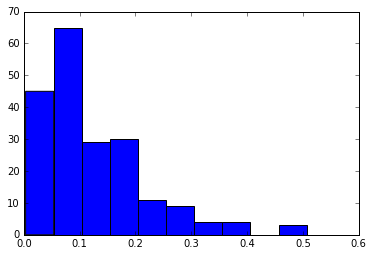

In [55]:
plt.hist(errs)

In [9]:
optimized_params

[-292.06198881701295,
 -22.784240722069956,
 275.69960736375606,
 0.4481786398402916,
 0.37351159802999351,
 -0.19545557597528221]

### Using sympy to check homogenous transformation matrix

In [ ]:
import sympy
xt, yt, zt, alpha, beta, gamma = sympy.symbols("xt, yt, zt, alpha, beta, gamma")

def sym_rotx(theta):
    ct = sympy.cos(theta)
    st = sympy.sin(theta)
    return sympy.Matrix([[1,  0,    0,  0],
                     [0,  ct, -st,  0],
                     [0,  st,  ct,  0],
                     [0,  0,    0,  1]])

def sym_roty(theta):
    ct = sympy.cos(theta)
    st = sympy.sin(theta)

    return sympy.Matrix([[ct,   0,   st, 0],
                     [0,    1,    0, 0],
                     [-st,  0,   ct, 0],
                     [  0,  0,    0, 1]])

def sym_rotz(theta):
    ct = sympy.cos(theta)
    st = sympy.sin(theta)

    return sympy.Matrix([[ct,      -st,  0, 0],
                     [st,       ct,  0, 0],
                     [ 0,        0,  1, 0],
                     [ 0,        0,  0, 1]])

def transl(x, y=None, z=None):
    return sympy.Matrix([[1., 0, 0, x],
                     [0, 1, 0, y],
                     [0, 0, 1, z],
                     [0, 0, 0, 1]])



transl(xt,yt,zt) * sym_rotz(alpha)*sym_roty(beta)*sym_rotx(gamma)